In [36]:
import numpy as np
import sched as sp
import opt_einsum as oe
import matplotlib.pyplot as plt
import os

np.set_printoptions(threshold=np.inf, linewidth=np.inf)

from quant_rotor.core.dense.hamiltonian import hamiltonian_dense
from quant_rotor.models.dense.density_matrix import density_matrix_1, density_matrix_2
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general_dense

# Check dencity matrix 

In [ ]:
site = 3
state = 11
g = 1

In [ ]:
HKV = hamiltonian_dense(state, site, g)

H = HKV[0]
V = HKV[2]

In [ ]:
H_NO, _, _ = hamiltonian_general_dense(state, site, g)

In [25]:
eig_val, eig_vec = np.linalg.eigh(H)

KeyboardInterrupt: 

In [ ]:
eig_val_NO, eig_vec_NO = np.linalg.eigh(H_NO)

In [ ]:
np.allclose(np.sort(eig_val), np.sort(eig_val_NO), atol=1e-20)

# Check 1-d, 2-d eigenvalue ocupation.

In [46]:
site = 3
state = 11
g = 1

In [47]:
H, K, V = hamiltonian_dense(state, site, g, periodic=False)

In [48]:
eig_val, eig_vec = np.linalg.eigh(H)

index = np.argmin(eig_val)
ground_state_vec = eig_vec[:, index]

In [49]:
D_1 = density_matrix_1(state, site, ground_state_vec, 0)
D_2 = density_matrix_2(state, site, ground_state_vec, 0, 1)

In [50]:
eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(state**2, state**2))

In [51]:
-np.sort(-eig_val_D_1)

array([5.84326902e-01, 3.99909893e-01, 1.23360919e-02, 2.28833286e-03, 1.09769234e-03, 2.73011837e-05, 1.36233874e-05, 8.67965622e-08, 7.60751971e-08, 2.01004335e-10, 1.45969309e-10])

In [52]:
-np.sort(-eig_val_D_2)

array([ 5.84326902e-01,  3.99909893e-01,  1.23360919e-02,  2.28833286e-03,  1.09769234e-03,  2.73011837e-05,  1.36233874e-05,  8.67965622e-08,  7.60751971e-08,  2.01004370e-10,  1.45969352e-10,  1.23395566e-16,  1.20902595e-16,  1.11359844e-16,  7.53161531e-17,  5.76366648e-17,  2.84353892e-17,  2.36530139e-17,  1.27378364e-17,  9.91881927e-18,  7.54979084e-18,  4.16372712e-18,  3.51454608e-18,  2.76896039e-18,  2.24648243e-18,  1.51987604e-18,  5.94368441e-19,  3.96000744e-19,  3.10449114e-19,  2.48763576e-19,  1.14337528e-19,  6.01852516e-20,  3.43063858e-20,  1.79956851e-20,  8.59645741e-21,  8.02222218e-21,  4.78801610e-21,  4.16682574e-21,  2.64913872e-21,  1.75372831e-21,  7.77054772e-22,  4.63098789e-22,  4.26246247e-22,  2.47558867e-22,  1.50916007e-22,  9.65368990e-23,  3.87421538e-23,  3.30921447e-23,  1.63601777e-23,  8.10210148e-24,  5.58127143e-24,  3.02054250e-24,  2.28386183e-24,  1.82049084e-24,  5.32347097e-25,  4.83803471e-25,  4.18103072e-25,  2.38262016e-25,  1.3111

In [53]:
index = np.argsort(-eig_val_D_1)

eig_vec_D_1[:, index[:2]]

array([[ 9.74979741e-01+0.j,  2.34428702e-16-0.j],
       [-2.22044605e-16+0.j,  7.06557570e-01+0.j],
       [ 1.79576524e-16+0.j, -7.06557570e-01+0.j],
       [-1.57173213e-01+0.j, -1.62061737e-16+0.j],
       [-1.57173213e-01+0.j,  1.38426516e-16+0.j],
       [ 5.22265009e-18+0.j, -2.78635893e-02+0.j],
       [-6.22082126e-18+0.j,  2.78635893e-02+0.j],
       [ 1.95784769e-03+0.j,  2.72976992e-16+0.j],
       [ 1.95784769e-03+0.j,  1.51546348e-16+0.j],
       [-2.71570702e-20+0.j,  1.43316685e-04+0.j],
       [ 2.71259283e-20+0.j, -1.43316685e-04+0.j]])

## Plot graphs

In [27]:
def load_one_simulation_ED(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.1f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    eigvals_path = os.path.join(directory, f"eigvals_{base}.npy")
    eigvecs_path = os.path.join(directory, f"eigvecs_{base}.npy")

    try:
        eigvals = np.load(eigvals_path)
        eigvecs = np.load(eigvecs_path)

        return eigvals, eigvecs

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return None

In [28]:
def load_one_simulation_NO(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.1f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    eigvals_path = os.path.join(directory, f"NO_eigvals_{base}.npy")
    eigvecs_path = os.path.join(directory, f"NO_eigvecs_{base}.npy")
    NO_basis_path = os.path.join(directory, f"NO_basis_{base}.npy")

    try:
        eigvals = np.load(eigvals_path)
        eigvecs = np.load(eigvecs_path)
        NO_basis = np.load(NO_basis_path)

        return eigvals, eigvecs, NO_basis

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return {}

In [29]:
def scatter_and_fit(g, y, label, color, degree=10, visible_indices=None):
    """
    Plot selected points from (g, y), fit to full data, and draw the fit curve.

    Parameters:
        g, y: full data arrays
        label: label for legend
        color: color for plot
        degree: degree of polynomial fit
        visible_indices: indices of points to show in the scatter plot
    """
    g = np.asarray(g)
    y = np.asarray(y)

    if visible_indices is not None:
        g_visible = g[visible_indices]
        y_visible = y[visible_indices]
    else:
        g_visible = g
        y_visible = y

    # Show only selected data points
    plt.scatter(g_visible, y_visible, label=f"{label}", color=color, s=30)

    # Fit to full data
    coeffs = np.polyfit(g, y, degree)
    poly_fn = np.poly1d(coeffs)

    # Plot fitted polynomial
    g_smooth = np.linspace(g.min(), g.max(), 300)
    y_smooth = poly_fn(g_smooth)
    plt.plot(g_smooth, y_smooth, linestyle='--', color=color)

In [30]:
file_path_ED = "./quant_rotor/data/ED_analisis_data"
file_path_ED_s = "./quant_rotor/dataED_analisis_data_sparce"
file_path_T_amplitudes = "./quant_rotor/dataT_amplitudes_energy"

In [ ]:
si3_st11_ED = []
si3_st5_NO = []
si5_st5_NO = []
si7_st3_NO = []
g_array = []

for g_index in range(1, 51):
    g = g_index / 10
    g_array.append(g)

    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index]

    D_1 = density_matrix_1(3, 11, ground_state_vec, 0)
    D_2 = density_matrix_2(3, 11, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(state**2, state**2))

    si3_st11_ED.append(-np.sort(-eig_val_D_1)[:2], -np.sort(-eig_val_D_2)[:2])

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index]

    D_1 = density_matrix_1(3, 11, ground_state_vec, 0)
    D_2 = density_matrix_2(3, 11, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(state**2, state**2))

    si3_st5_NO.append(-np.sort(-eig_val_D_1)[:2], -np.sort(-eig_val_D_2)[:2])

    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index]

    D_1 = density_matrix_1(3, 11, ground_state_vec, 0)
    D_2 = density_matrix_2(3, 11, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(state**2, state**2))

    si5_st5_NO.append(-np.sort(-eig_val_D_1)[:2], -np.sort(-eig_val_D_2)[:2])

    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)

    index_array = np.argmin(eig_val)
    ground_state_vec = eig_vec[:, index]

    D_1 = density_matrix_1(3, 11, ground_state_vec, 0)
    D_2 = density_matrix_2(3, 11, ground_state_vec, 0, 1)

    eig_val_D_1, eig_vec_D_1 = np.linalg.eigh(D_1)
    eig_val_D_2, eig_vec_D_2 = np.linalg.eigh(D_2.reshape(state**2, state**2))

    si3_st11_ED.append(-np.sort(-eig_val_D_1)[:2], -np.sort(-eig_val_D_2)[:2])

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43108/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43108/1165677915.py:26: RankWar

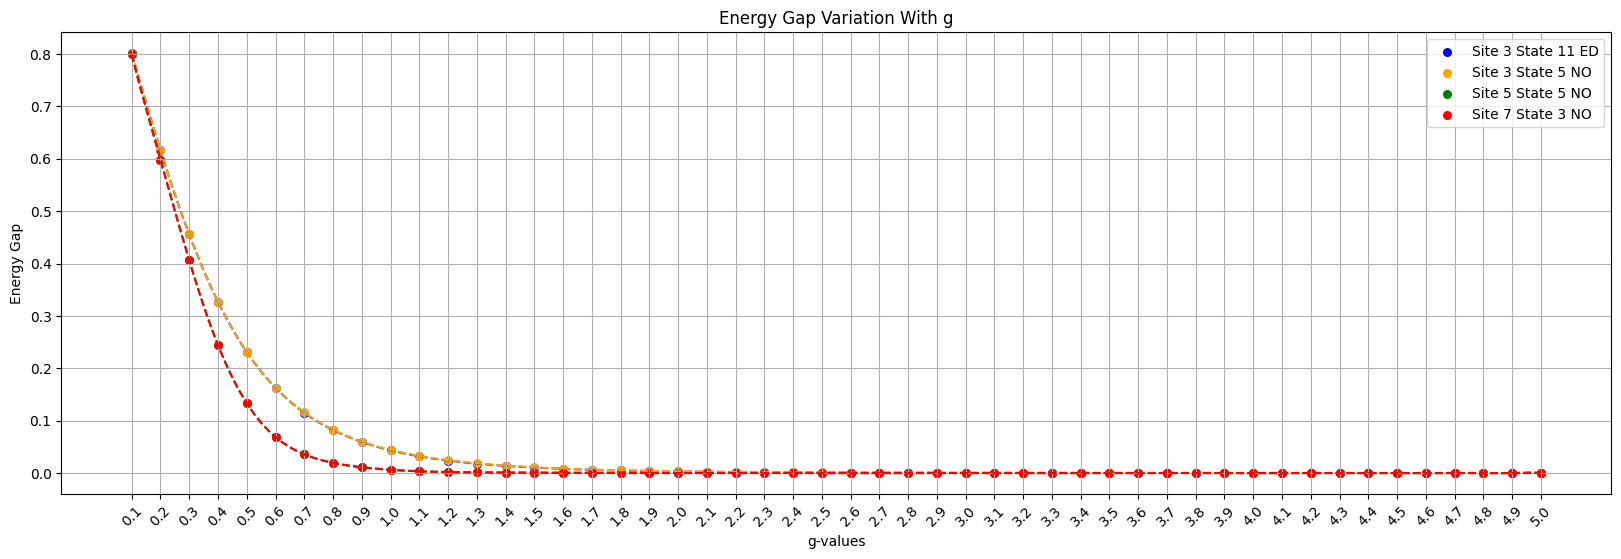

In [35]:
si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

dim_fit = 20

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(20, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)

# Axis formatting
plt.xticks(g_array, rotation=45)
plt.xlabel("g-values")
plt.ylabel("Energy Gap")
plt.title("Energy Gap Variation With g")
plt.legend()
plt.grid(True)
plt.show()

si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

visible_idx = np.r_[0:10, 19, 49]